# CYPLAN101 Fall 2025 - Lab 6: Basics of Geopandas Wrangling & Data Visualization

## Learning Objectives:
* Load, filter, and visualize geospatial data using Geopandas
* Apply appropriate coordinate reference systems and projections to geospatial datasets
* Perform geocoding operations to convert addresses into geographic coordinates
* Execute spatial joins using various spatial relationship operations
* Create multi-layer maps to visualize spatial relationships between datasets


---
## Part I. Geopandas Basics and Loading Data
In this lab exercise, you will be producing a map containing three layers:  
  * The City of Berkeley Jurisdictional Boundary,
  * A choropleth map depicting Median Household Income for each census tract, and
  * Point locations of your favorite locations around campus.

To kick things off, you will install Geopandas and its dependencies, then load geospatial data from various file formats (Geopackage, GeoJSON). Then you will explore Geopandas capabilities and optionally learn to create interactive visualizations using Plotly Express.


### Step 1: Install Geopandas and Dependencies
Begin by installing Geopandas in your Python environment using the following command.  You can do this in the terminal or in a code cell.

```
pip install geopandas
```

  > **Hint:** What packages do you need to install in addition to installing geopandas?


In [1]:
%pip install geopandas census us --quiet

Note: you may need to restart the kernel to use updated packages.


### Step 2: Import Required Libraries
Import Geopandas and other necessary libraries using the code cell below.  

> **Hint:** You may need to return to this code cell over the span of this exercise to add dependencies.

In [2]:
import os
import pandas as pd
import geopandas as gpd
from us import states
import matplotlib.pyplot as plt
from census import Census

with open("censusAPIKey.txt", "r") as file:
    censusAPIKey = file.read().strip()

census_data = Census(censusAPIKey)

### Step 3: Download Berkeley Jurisdictional Boundary Data

As we have discussed, GIS data can be found in a variety of different formats. **For Example:**
  * GeoJSONs are a JSON-based open standard format for encoding geographic data structures. GeoJSON works well with web applications and all content (e.g., geometry + attributes) is stored in a single .geojson or .json file.

  * GeoPackages are an open-standard format based on SQLite. GeoPackages are single .gpkg files that can store multiple layers of vector and raster data, plus metadata. This is the format recommended by the [Open Geospatial Consortium](https://www.ogc.org/) (OGC).

  * **Shapefiles** are a format developed by ESRI in the 1990s that stores vector geographic data. A "shapefile" is actually a collection of multiple files that must stay together:
    - `.shp` - the geometry (points, lines, polygons)
    - `.shx` - the index file
    - `.dbf` - the attribute data (like a spreadsheet)
    - `.prj` - the coordinate reference system
    - Optional: `.cpg`, `.sbn`, `.sbx`, etc.

**Today we will be working with the GeoJSON file format when sourcing input data from the [City of Berkeley's Open Data Portal](https://data.cityofberkeley.info/).**  
Using the link provided above, search for, and download the latest version of the Berkeley jurisdictional boundary as a GeoJSON file.

> **Hint:** If the download fails, you can also find a copy of this file in the course files on the lab page.

<br>

**Once you have downloaded the file, remember to upload it to your working directory in Colab.**

### Step 4: Load the Geospatial Data
Read the Berkeley boundary file into a GeoDataFrame.  You can use the template code below to do this.

```
gdf = gpd.read_file('your_file_name.geojson')
```
Once you have loaded your data, preview it using `.plot()`

```
gdf.plot()
```

##❗️ Try it Out ❗️
In the cell below, adapt the template code to load your geojson file into the current Colab runtime environment.  

**Be sure to remember this variable name!  You will need it again later in this lab exercise**

<Axes: >

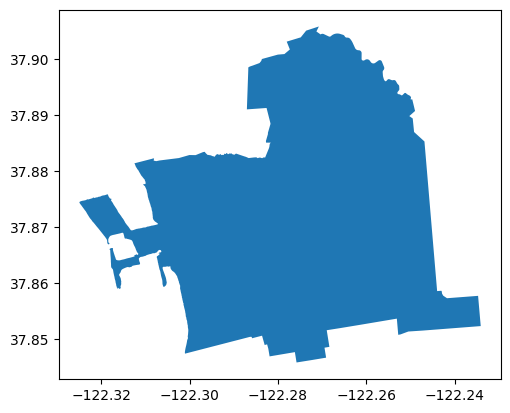

In [5]:
# Load in your data here.
gdf = gpd.read_file('data/berkeley_land_boundary_2024.geojson')

# Plot your data here.
gdf.plot()


### Step 5: Load Your Census Data
In this step, you will again use the Census API to load in your data. This time, however, you will be combining tract tabular data (attributes) with tract geometry (features).

  > **Note:** If the Census API is not working, you have two options.  While you can download the data as a GeoJSON file and tabular data from the course files, I would strongly encourage you to try extracting the data from IPUMS NHGIS database. **We will cover this at a later time.** This will require you to apply a slightly different workflow.

**To complete this step, you will need to install/import several dependencies first:**

```
import os
import pandas as pd
from census import Census
from us import states
```
Using the Step 1 code cell above (and/or the terminal) please load in these dependencies.

**You will also need to toggle on the Census Data API key in the "Secrets" sidebar and add the key into your environment.  As a reminder, the code for this will look like this:**

```
from google.colab import userdata
censusAPIKey = Census(
    os.getenv(
        userdata.get('censusAPIKey')
        ))
```

**You can do this in the Step 1 code cell as well**

##❗️ Try it Out ❗️
In the code cell below, adapt the code  to retrieve the **2023 ACS 5-year Estimates for Population (B01003_001E) and Median Household Income (B19013_001E) for all census tracts in Alameda County**

In [6]:
alamedaCountyTracts = census_data.acs5.state_county_tract(
    fields=('NAME', 'B01003_001E', 'B19013_001E'),
    state_fips= '06',
    county_fips='001',
    tract='*',
    year = 2023
)

# Convert to DataFrame
alamedaDataframe = pd.DataFrame(alamedaCountyTracts)

# Rename columns for clarity
alamedaDataframe = alamedaDataframe.rename(columns={
    'TABLE 1': 'population',
    'TABLE 2': 'median_household_income'
})

Now that you have loaded in your tabular data, its time to retrieve the geometry and join it to the tabular data.  To do this, you will need to construct a GEOID field and then use geopandas to download census tract geometry.

#### **Recall the basic components of a GEOID from Lab:**

| Area Type          | GEOID Structure                | Example (Alameda County, CA) |
| ------------------ | ------------------------------ | ---------------------------- |
| State              | STATE (2 digits)               | `06`                         |
| County             | STATE + COUNTY (2+3)           | `06001`                      |
| Census Tract       | STATE + COUNTY + TRACT (2+3+6) | `06001400100`                |
| Census Block Group | STATE + COUNTY + TRACT + BG    | `060014001001`               |


Based on the columns from your extracted census tract data, you can perform a vectorized operation to create a new GEOID column.

In [7]:
# Use this space to create a new GEOID column
alamedaDataframe['GEOID'] = alamedaDataframe['state'] + \
  alamedaDataframe['county'] + \
  alamedaDataframe['tract']

alamedaDataframe.head(3)

,NAME,B01003_001E,B19013_001E,state,county,tract,GEOID
0,Census Tract 4001; Alameda County; California,3094.0,250001.0,06,001,400100,06001400100
1,Census Tract 4002; Alameda County; California,2093.0,225880.0,06,001,400200,06001400200
2,Census Tract 4003; Alameda County; California,5727.0,157731.0,06,001,400300,06001400300


 Now that you have a field upon which to base your join/merge you can go ahead and retrieve the census tract geometries.  

 To do this, navigate to the [census TIGER file FTP site](https://www2.census.gov/geo/tiger/) and locate the zip file for tracts in California that corresponds to 2023 data.

  >**Hint:** Grab the URL for the ZIP file located at...TIGER2023 > TRACT > ...WHAT FIPS CODE IS THE STATE OF CALIFORNIA?

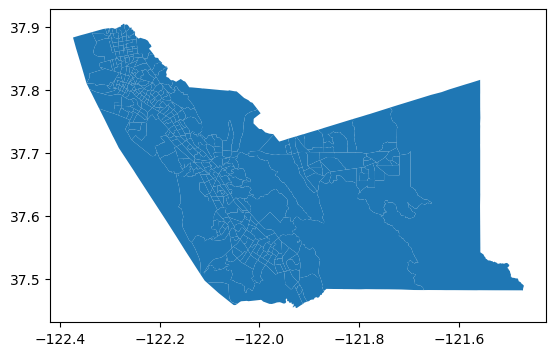

In [ ]:
# Edit the code below to read in the Census TIGER file containing the geometry for each tract in the State of California
caTracts = gpd.read_file(
    "data/tl_2023_06_tract.zip"
)
# display(caTracts.head(3))

# Edit the code below to join census data with geometries
alamedaCensusGdf = caTracts.merge(alamedaDataframe, on='GEOID', how='right')


# Plot the result
alamedaCensusGdf.plot()

# Optional: Save the result as a geopackage
alamedaCensusGdf.to_file("data/alamedaCensusGdf.gpkg", driver="GPKG")


##❗️ Try it Out ❗️
In the cell below, perform the following tasks to explore the data.  **Be sure to use print statements to ensure the results are displayed in the output.**

  * Print the first 5 rows of the GeoDataFrame
  * Identify the types of each column in the GeoDataFrame
  * View basic **information** about the GeoDataFrame
  * Check the **geometry** of the GeoDataFrame
  * Check the crs of the GeoDataFrame

  > **Hint:** You can use the `geometry` method and the `crs` method to retrieve the last two items on this list.



In [9]:
# Use this space to print the first 5 rows of the GeoDataFrame
display(alamedaCensusGdf.head(5))

# Use this space to identify the types of each column in the GeoDataFrame
print("\nColumns:", [column for column in alamedaCensusGdf.columns])

# Use this space to view basic information about the GeoDataFrame
print("\nBasic Info:\n")
print(alamedaCensusGdf.info())

# Use this space to check the geometry of the GeoDataFrame
print(f"\nGeometry Check:\n{alamedaCensusGdf.geometry}")

# Use this space to check the crs of the GeoDataFrame
print(f"\nCRS Information:{alamedaCensusGdf.crs}")


,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,NAME_y,B01003_001E,B19013_001E,state,county,tract
0,06,001,400100,06001400100,1400000US06001400100,4001,Census Tract 4001,G5020,S,6945856,0,+37.8676563,-122.2318813,"POLYGON ((-122.24691 37.88536, -122.24664 37.8...",Census Tract 4001; Alameda County; California,3094.0,250001.0,06,001,400100
1,06,001,400200,06001400200,1400000US06001400200,4002,Census Tract 4002,G5020,S,586560,0,+37.8481378,-122.2495916,"POLYGON ((-122.25792 37.84261, -122.25773 37.8...",Census Tract 4002; Alameda County; California,2093.0,225880.0,06,001,400200
2,06,001,400300,06001400300,1400000US06001400300,4003,Census Tract 4003,G5020,S,1110840,0,+37.8405841,-122.2544782,"POLYGON ((-122.26563 37.83764, -122.26556 37.8...",Census Tract 4003; Alameda County; California,5727.0,157731.0,06,001,400300
3,06,001,400400,06001400400,1400000US06001400400,4004,Census Tract 4004,G5020,S,716138,0,+37.8482840,-122.2574447,"POLYGON ((-122.26183 37.84162, -122.2618 37.84...",Census Tract 4004; Alameda County; California,4395.0,159612.0,06,001,400400
4,06,001,400500,06001400500,1400000US06001400500,4005,Census Tract 4005,G5020,S,591424,0,+37.8485452,-122.2647353,"POLYGON ((-122.26951 37.84858, -122.26937 37.8...",Census Tract 4005; Alameda County; California,3822.0,96250.0,06,001,400500



Columns: ['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'GEOIDFQ', 'NAME_x', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'NAME_y', 'B01003_001E', 'B19013_001E', 'state', 'county', 'tract']

Basic Info:

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   STATEFP      379 non-null    object  
 1   COUNTYFP     379 non-null    object  
 2   TRACTCE      379 non-null    object  
 3   GEOID        379 non-null    object  
 4   GEOIDFQ      379 non-null    object  
 5   NAME_x       379 non-null    object  
 6   NAMELSAD     379 non-null    object  
 7   MTFCC        379 non-null    object  
 8   FUNCSTAT     379 non-null    object  
 9   ALAND        379 non-null    int64   
 10  AWATER       379 non-null    int64   
 11  INTPTLAT     379 non-null    object  
 12  INTPTLON     379 non-null    object

---
## Part II. Geocoding and Projections

In this section you will learn how vector geospatial data (points, lines, polygons) is stored.  You will also check and set coordinate systems and perform spatial filtering to select census tracts within Berkeley and geocode addresses from your **Assignment #2** CSV file.


### Step 1: Geocode your own data
Thus far, you have prepared data for two of the three layers to be included in our map, namely the Berkeley jurisdictional boundary and the Berkeley tracts.  Now you will bring in your own original data using a process called **geocoding**.

Geocoding is the process of converting text-based location descriptions (like addresses or place names) into geographic coordinates (latitude and longitude) that can be mapped and analyzed spatially.



##❗️ Try it Out ❗️
Download your Assignment #2 CSV file from gradescope and edit the code cell below to geocode it.

For this step, you can use the following template code:
```
geoCodedData = gpd.tools.geocode(addresses)

geoCodedData
```

In [ ]:
# Use this space to read in your csv file containing your Assignment #2 submission
places = gpd.read_file("data/manuel_1809266_A2.csv")
places.head()

# Use this space to apply the gpd.tools.geocode() function to your data
# Hint: Use the argument timeout = 10 to circumvent timeout error issues
if 'berkeley_places_gdf' in globals():
  print('Already loaded.')
else:
  berkeley_places_gdf = gpd.tools.geocode(places['address'])

# Use this space to check the type of the resulting GDF
print(berkeley_places_gdf.head(5))

# Use this space to check the CRS of the resulting GDF
print(berkeley_places_gdf.crs)

berkeley_places_gdf.to_file("data/berkeley_places_gdf.gpkg", driver="GPKG")

                      geometry  \
0  POINT (-122.26285 37.86765)   
1   POINT (-122.26814 37.8701)   
2  POINT (-122.25842 37.86302)   
3  POINT (-122.25882 37.86769)   
4   POINT (-122.26814 37.8701)   

                                             address  
0  Berkeley City Club, 2315, Durant Avenue, 94701...  
1  Downtown Berkeley, 2160, Shattuck Avenue, 9470...  
2  7-Eleven, 2601, Telegraph Avenue, 94704, Teleg...  
3  Super Duper Burger, 2355, Telegraph Avenue, 94...  
4  Downtown Berkeley, 2160, Shattuck Avenue, 9470...  
EPSG:4326


### Step 2: Vector Data Types and Projections

In this exercise we are working with several different **geospatial datatypes** and two different different **Coordinate Reference Systems (CRS)**.

#### Geospatial Data Types
We are contending with both point and polygon data:

Recall the three types of vector geometries:

* **Points** - stored as single coordinate pairs (x, y)
* **Lines** - stored as ordered sequences of coordinate pairs
* **Polygons** - stored as closed sequences of coordinate pairs (first point = last point)


#### Coordinate Reference Systems (CRS)
 Recall that a CRS is a framework that defines how geographic coordinates (like latitude and longitude) relate to actual locations on Earth's surface, specifying the projection, datum, and units used to represent spatial data.


##❗️ Try it Out ❗️
Use the code cell below to check (again) the coordinate reference systems for each of your GeoDataFrames.  If you are unsure which variable corresponds to a GeoDataFrame, you can check this easily using the **Variables** button in the bottom lefthand corner of the browser viewport.

Do you notice a discrepancy in the CRS within any of the GeoDataFrames?  In addition to the foregoing task, you should also correct this discrepancy in the code cell below. You can use the following template code to do this:

```
gdf = gdf['geometry'].to_crs('COORDINATE REFERENCE SYSTEM HERE')
```

In [9]:
# Use this space to print the CRS of the Berkeley jurisdictional boundary
print(f"Berkeley Jurisdiction Boundary CRS: {gdf.crs}")

# Use this space to print the CRS of tracts within Alameda County
print(f"Alameda County CRS: {alamedaCensusGdf.crs}")

# Use this space to print the CRS of your geocoded point locations from Assignment #2
print(f"My Assignment's CRS: {berkeley_places_gdf.crs}")

# Use this space to update any CRS that does not match the other CRS from our prospective map layers.
alamedaCensusGdf['geometry'] = alamedaCensusGdf['geometry'].to_crs('EPSG:4326')
print(f"Updated Alameda County CRS: {alamedaCensusGdf.crs}")


Berkeley Jurisdiction Boundary CRS: EPSG:4326
Alameda County CRS: EPSG:4269
My Assignment's CRS: EPSG:4326
Updated Alameda County CRS: EPSG:4326


### Step 3: Simple Spatial Filter - Select Census Tracts Within Berkeley

Recall that during the previous lab exercise you performed a tabular join using the merge function.   

Today, you will perform a spatial join based on geographic location of two GeoDataFrames.  A spatial join can occur between layers of many types.  For example, you might perform a spatial join to identify points representing locations where a taxi driver picked up an individual within a particular zip code.

Recall that to perform a perform a spatial join you would use `gdf.sjoin()`

Arguments for this function include:
  * The reference GDF
  * The join type (e.g., `how='inner'`)
  * The predicate (e.g., `predicate = 'within'` - or possibly...'contains', 'touches', 'crosses', 'overlaps')










##❗️ Try it Out ❗️

Using the template code and guidance above, write a spatial join that creates a new GeoDataFrame containing only the  tracts that intersect with Berkeley's juriscitional bounds.  


<Axes: >

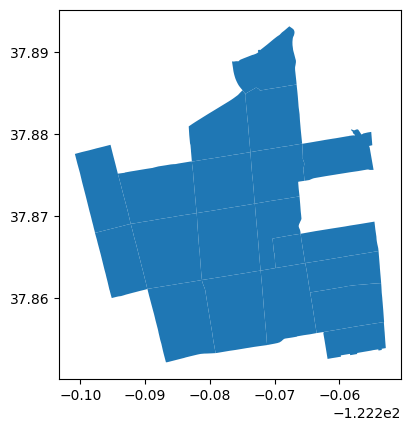

In [ ]:
# Use this space to create your join and new GeoDataFrame
joined_gdf = alamedaCensusGdf.sjoin(gdf, how='inner', predicate='within')
joined_gdf.to_file("data/berkeley_census_tracts_gdf.gpkg", driver="GPKG")

# Use this space to plot the result
joined_gdf.plot()

---
## Part III. Basic Visualization and Spatial Analysis
In this final part of the lab, you will create static maps using matplotlib and overlay your three GeoDataFrames.

### Step 1: Creating a Map Using matplotlib

You may have noticed that the .plot function provides only basic functionality.  There are many plotting libraries available for maps, but today you will continue using the default, **matplotlib**, a common and versatile Python plotting library.

First we will be updating the **symbology** for just one of our three layers to improve visualization.  

You may use the following code template to do this.

```
gdf.plot(facecolor=, edgecolor=, linewidth=)
plt.show()
```
  > **Note:** `plt.show()` displays the matplotlib figure/plot in a window or inline in a Jupyter notebook, rendering all the plotting commands that were called before it.
  
  <br>

  > **Hint:** You can use the [matplotlib cheat sheet](https://matplotlib.org/cheatsheets/_images/cheatsheets-1.png) and [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html) to determine the appropriate arguments for this.  

##❗️ Try it Out ❗️
Using the template code above, plot only your Berkeley jurisdictional boundary GDF.

**You should apply a black outline and a white or transparent fill.**

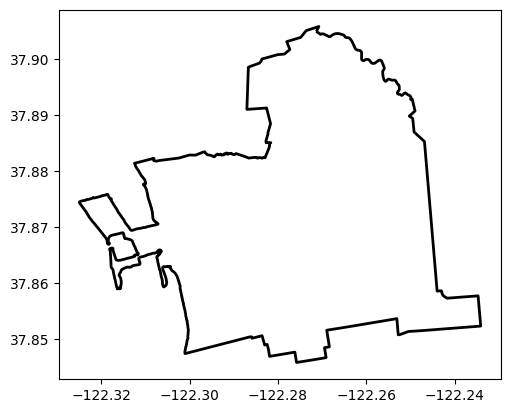

In [11]:
# Use this code cell to adapt the template code and plot only the Berkeley jurisdictional boundary with a black outline and white or transparent fill
fig, ax = plt.subplots()
gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)
plt.show()

### Step 2: Creating Maps with Multiple Layers Using matplotlib and downloading plots
One of the benefits of GIS and mapping in general is the ability to layer multiple types of data upon one another to add context and convey information. Matplotlib has this functionality In this final step you will be applying the following template code to do just that with all three of your layers.  

```
fig, ax = plt.subplots()

gdf1.plot(ax=ax)
gdf2.plot(ax=ax)
gdf3.plot(ax=ax)

plt.show()
```

To download the result, simply add
`plt.savefig('filename.png')` before `plt.show()`.

  > **Hint:** Be careful about the layer draw order!

##❗️ Try it Out ❗️
Using the template code above, plot all three of your layers using the following symbology:

1. Berkeley jurisdictional boundary - apply a black outline and white fill
2. Berkeley Census Tract Boundaries - as a choropleth layer (Hint: `gdf.plot(column=, cmap=, legend=True)`)
3. Plot the point locations from your Assignment #2 submission - symbolize according to the location type (e.g., restaurant, study spot etc.)


**Download the resulting map as a PNG file.**


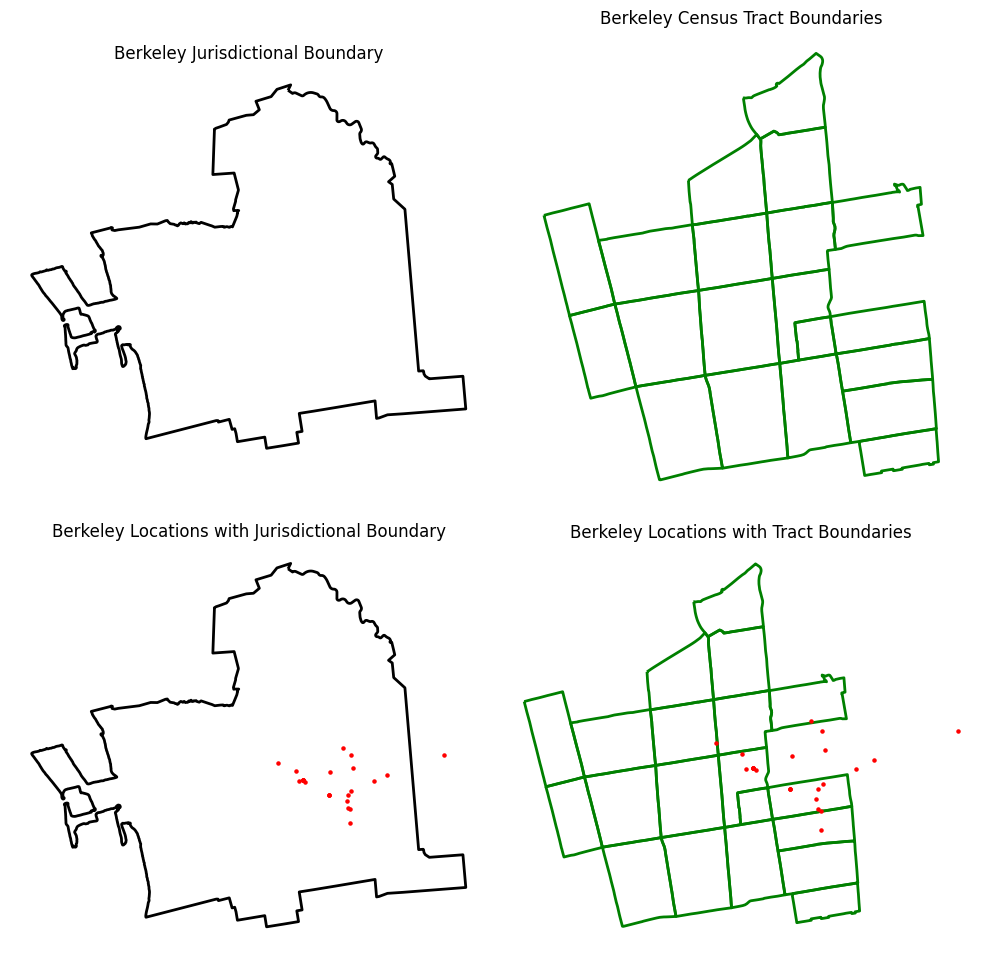

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
# Jurisdictional boundary subplot
gdf.plot(ax=ax[0, 0], facecolor='none', edgecolor='black', linewidth=2)
ax[0,0].set_title('Berkeley Jurisdictional Boundary')
ax[0,0].axis('off')

# Berkeley Census Tract Boundaries
joined_gdf.plot(ax=ax[0, 1], facecolor='none', edgecolor='green', linewidth=2)
ax[0,1].set_title('Berkeley Census Tract Boundaries')
ax[0,1].axis('off')

# Berkeley Locations with Jurisdicitonal Boundary Plot
gdf.plot(ax=ax[1, 0], facecolor='none', edgecolor='black', linewidth=2)
berkeley_places_gdf.plot(ax=ax[1, 0], color='red', markersize=5)
ax[1,0].set_title('Berkeley Locations with Jurisdictional Boundary')
ax[1,0].axis('off')

# Berkeley locations with Tract Boundaries
joined_gdf.plot(ax=ax[1, 1], facecolor='none', edgecolor='green', linewidth=2)
berkeley_places_gdf.plot(ax=ax[1, 1], color='red', markersize=5)
ax[1,1].set_title('Berkeley Locations with Tract Boundaries')
ax[1,1].axis('off')

plt.tight_layout()
plt.savefig("figures/berkeley_analysis_plots.png", dpi=300)
plt.show()

---
# Important Submission Instructions

* **Submit your lab at the end of the class period.**
* Complete all three parts of the lab by the next lab session. This assignment builds upon itself, and completion of all sections is essential for next week's lab work.
* Navigate to bCourses to review the full submission instructions.
* Submit your completed work through the bCourses platform by the specified deadline.